# Assess Stretch Errors

Code for analyzing how the stretch of the hemp line in Gazelle data might influence the calculated temperature change in Wenegrat et al. 2022 (doi:10.1029/2022GL098217).

In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install regionmask

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
from scipy.optimize import lsq_linear
from typing import Iterable
from scipy import stats
import pyproj as proj
import scipy.interpolate as interpolate
import regionmask
import scipy.integrate as integrate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.font_manager
#font = {'family': 'serif', 'serif': ['Palatino'], 'size': 14}
#plt.rc('font', **font)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=False)
#plt.rc('text', usetex=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# load the pickle to consider
# cruise_df = pd.read_pickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl')
import sys
sys.path.insert(0,'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/src')
from importlib import reload
import loadPickle as loadPickle
reload(loadPickle)
cutlat = -50
cruise_df = loadPickle.loadPickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl', cutlat)
ac = cruise_df
ac

<xarray.Dataset>
Dimensions:                    (index: 534)
Coordinates:
  * index                      (index) int64 10 11 12 13 14 ... 615 616 617 618
Data variables: (12/40)
    Station                    (index) object '40' '40' '40' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-08 ... 1906-08-14
    Lat degrees                (index) float64 -39.0 -39.0 -39.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -9.5 -9.5 -9.5 ... -18.0 -18.0
    Lon degrees                (index) float64 20.0 20.0 20.0 ... 112.0 112.0
    Lon minutes                (index) float64 56.0 56.0 56.0 ... 9.0 9.0 9.0
    ...                         ...
    delta_T_seasonal_5564      (index) float64 -1.05 -1.454 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 18.15 16.85 15.55 ... 8.873 1.416
    delta_T_merged             (index) float64 -0.6061 -0.3704 ... -0.3018
    WOA_temp                   (index) float64 18.59 17.93 16.96 ... 8.995 1.398
    delta_T_merged_5564        (index) float64 -1.832 -1.609 ... -0.8942 -0.2845
    WOA_temp_5564              (index) float64 17.37 16.69 15.22 ... 8.706 1.416

In [ ]:
#Print dates out
ga = ac.where(ac.cruise=='Gazelle', drop=True)
print(f'Gazelle: {ga.Date.min()}-{ga.Date.max()}')
ga = ac.where(ac.cruise=='Valdivia', drop=True)
print(f'Valdivia: {ga.Date.min()}-{ga.Date.max()}')
ga = ac.where(ac.cruise=='Planet', drop=True)
print(f'Valdivia: {ga.Date.min()}-{ga.Date.max()}')

Gazelle: <xarray.DataArray 'Date' ()>
array('1874-10-08T00:00:00.000000000', dtype='datetime64[ns]')-<xarray.DataArray 'Date' ()>
array('1875-05-05T00:00:00.000000000', dtype='datetime64[ns]')
Valdivia: <xarray.DataArray 'Date' ()>
array('1899-01-05T00:00:00.000000000', dtype='datetime64[ns]')-<xarray.DataArray 'Date' ()>
array('1899-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Valdivia: <xarray.DataArray 'Date' ()>
array('1906-04-17T00:00:00.000000000', dtype='datetime64[ns]')-<xarray.DataArray 'Date' ()>
array('1906-08-14T00:00:00.000000000', dtype='datetime64[ns]')


## LOAD WOA

In [ ]:

# #url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/1.00/woa18_A5B7_t00_01.nc' # ARGO
# url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/0.25/woa18_A5B7_t00_01.nc' # ARGO
# WOA = xr.open_dataset(url, decode_times=False)

def url_month(month_number, old = False):
  #url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/decav/0.25/woa18_decav_t{month_number}_04.nc' # DECADAL
  url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/0.25/woa18_A5B7_t{month_number}_04.nc' # ARGO 1/4 degree
  if old:
    url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/5564/1.00/woa18_5564_t{month_number}_01.nc' # 5564 Era 1 degree (no 1/4 degree monthly avail)
  open_dataset = xr.open_dataset(url, decode_times=False)
  return open_dataset

#ARGO era
WOA01 = url_month('01')
WOA02 = url_month('02')
WOA03 = url_month('03')
WOA04 = url_month('04')
WOA05 = url_month('05')
WOA06 = url_month('06')
WOA07 = url_month('07')
WOA08 = url_month('08')
WOA09 = url_month('09')
WOA10 = url_month('10')
WOA11 = url_month('11')
WOA12 = url_month('12')

In [ ]:
WOA01

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 720, lon: 1440, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float32 72.5
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    ...                  ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_ma                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

# THE FUNCTION
NEED TO:

1.   Interpolate WOA to historical station (as in create pickle)
2.   Add some specificed percent error in the depth
3.   Return both the 'true' and the 'error' temp.




In [ ]:
crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

# This function calculates differences in temperature using seasonal data
# Inputs: 
#         - ind = index of row to calculate
#         - df. = dataframe to calculate on
#         - regrid = Flag on whether to regrid spatial coordinates
#         - avg.   = Flag on whether to use the naive averaged WOA temps
#         - old.   = Flag on whether to use the 5564 climatology
WLON, WLAT = np.meshgrid(WOA01.sel(lat=slice(-60, 30), lon=slice(0, 150)).lon, WOA01.sel(lat=slice(-60, 30), lon=slice(0, 150)).lat)
 

def WOA_stretch(ind, ds, error_fact=0.04):
  month_dict = {1:WOA01, 2:WOA02, 3:WOA03, 4:WOA04, 5:WOA05, 6:WOA06, 7:WOA07, 8:WOA08, 9:WOA09, 10:WOA10, 11:WOA11, 12:WOA12}
  month = (ds.Date[ind].values.astype('datetime64[M]').astype(int) % 12 + 1)

  woa_temp = month_dict[month]

  lats = ds.lat[i]
  lons = ds.lon[i]
  depths = ds.Depth[i]
  insitu_temp=woa_temp.sel(lat=slice(-60, 30), lon=slice(0, 150))['t_an']
  # Subset the WOA data and meshgrid for interpolation
  
  # Center the projection around the historical location
  cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lats.values,lons.values))
  x, y = proj.transform(crs_wgs, cust, lons, lats)
  # Interpolate woa vertically and flatten it (ravel)
  woaflat = np.ravel(insitu_temp.isel(time=0).interp(depth = depths, method='linear').values)
  mask = np.isfinite(woaflat)
  # transform the WOA lats and lons to cartesian distance
  fx, fy = proj.transform(crs_wgs, cust, WLON, WLAT)
  fxf = np.ravel(fx)
  fyf = np.ravel(fy)
    # do the horizontal interpolation
  newtemps = float(interpolate.griddata((fxf[mask], fyf[mask]), woaflat[mask], [x,y]))
  
  #newtemps = float(insitu_temp.isel(time=0).interp(lon=lons, lat=lats, depth=depths, method='linear').values)

  #Now redo but with the stretched depth
  woaflat = np.ravel(insitu_temp.isel(time=0).interp(depth = depths*(1-error_fact), method='linear').values)
  mask = np.isfinite(woaflat)
  # transform the WOA lats and lons to cartesian distance
  fx, fy = proj.transform(crs_wgs, cust, WLON, WLAT)
  fxf = np.ravel(fx)
  fyf = np.ravel(fy)
    # do the horizontal interpolation
  errortemp = float(interpolate.griddata((fxf[mask], fyf[mask]), woaflat[mask], [x,y]))
  #errortemp = float(insitu_temp.isel(time=0).interp(lon=lons, lat=lats, depth=depths*(1+error_fact), method='linear').values)

  return newtemps, errortemp

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
ni = ac.index.size
newc = ac.copy()
newc['StretchError'] = np.nan*newc.Temperature
for i in range(0, ni):
  print(f'Finished {i}/{ni}')
  if newc.cruise[i] == 'Gazelle':
    try:
      newtemps, error_temp = WOA_stretch(i, newc)
      newc['StretchError'][i] =newtemps - error_temp
    except:
      dummy = 0
  else:
    newc['StretchError'][i] = 0 # Only the Gazelle used hemp


Finished 0/534
Finished 1/534
Finished 2/534
Finished 3/534
Finished 4/534
Finished 5/534
Finished 6/534
Finished 7/534
Finished 8/534
Finished 9/534
Finished 10/534
Finished 11/534
Finished 12/534
Finished 13/534
Finished 14/534
Finished 15/534
Finished 16/534
Finished 17/534
Finished 18/534
Finished 19/534
Finished 20/534
Finished 21/534
Finished 22/534
Finished 23/534
Finished 24/534
Finished 25/534
Finished 26/534
Finished 27/534
Finished 28/534
Finished 29/534
Finished 30/534
Finished 31/534
Finished 32/534
Finished 33/534
Finished 34/534
Finished 35/534
Finished 36/534
Finished 37/534
Finished 38/534
Finished 39/534
Finished 40/534
Finished 41/534
Finished 42/534
Finished 43/534
Finished 44/534
Finished 45/534
Finished 46/534
Finished 47/534
Finished 48/534
Finished 49/534
Finished 50/534
Finished 51/534
Finished 52/534
Finished 53/534
Finished 54/534
Finished 55/534
Finished 56/534
Finished 57/534
Finished 58/534
Finished 59/534
Finished 60/534
Finished 61/534
Finished 62/534
Fi

## Next we bin the errors by depth

In [ ]:
bins = [-1, 1, 100, 300, 500, 1000, 2000, 3000]
bins = [-1, 1, 100, 500, 1000, 2000, 3000]
bins = [-1, 1, 100, 300, 500, 1000, 2000, 3000]
# group data by bins
binned_data = newc.groupby_bins('Depth', bins=bins, right=True, include_lowest=True).mean() 
binned_data_G = newc.where(newc.cruise=='Gazelle', drop=True).groupby_bins('Depth', bins=bins, right=True, include_lowest=True).mean() 


<xarray.DataArray 'StretchError' ()>
array(0.)
All cruises: -0.174884929249063
Gazelle Only: -0.31002328366879345


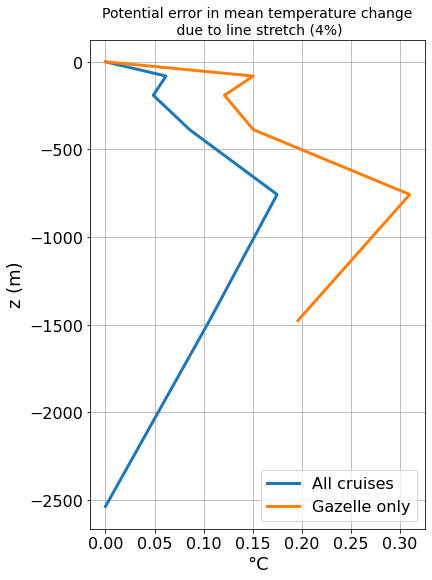

In [ ]:
x = binned_data['StretchError']
y = binned_data['Depth']
print(np.max(x))
plt.figure(figsize=(6, 9))

plt.plot(-x, -y, label='All cruises', linewidth=3)
print(f'All cruises: {np.min(x.values)}')
x = binned_data_G['StretchError']
print(f'Gazelle Only: {np.nanmin(x.values)}')

plt.plot(-x, -y, label='Gazelle only', linewidth=3)
plt.title('Potential error in mean temperature change\n due to line stretch (4%)', fontsize=14)
plt.ylabel('z (m)', fontsize=18)
plt.xlabel('°C', fontsize=18)
plt.legend(fontsize=16, loc='lower right')
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)

#plt.savefig('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/StretchErrors.pdf', bbox_inches='tight')